<h1> Pokemon Image Classifier </h1>
<h3> In the this project we will use CNNs to train a model that can identify pokemon  images<h3>


## Fetching the Data

In [1]:
# Importing the standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import shutil

<h2> Splitting data <h2>

<h3> In the following cells we seperate the pokemon data into train and test datasets <h3>

In [2]:
os.system('cp -r ../input/pokemonclassification/PokemonData .')

# Setting the path for pokemon data
path = 'PokemonData'
classes = os.listdir(path)

# Creating the train folder
os.system("mkdir PokemonData/Poke_train")

# Move all the folders from root folder to train folder, ignore the error
os.system("mv PokemonData/* PokemonData/Poke_train/")

# Creating the test folder
os.system("mkdir PokemonData/Poke_test")

# Copying all the data from train to test to get the same folder structure
os.system("cp -r PokemonData/Poke_train/* PokemonData/Poke_test/")

# Deleting all the files in the sub-directories  of the test folder
os.system("find PokemonData/Poke_test/ -name '*.*' -type f -delete")

# Setting the path for the train and test folder

train_path = 'PokemonData/Poke_train'
test_path = 'PokemonData/Poke_test'
#os.listdir(train_path)

In [3]:
# Copying 15 random images from train folders to test folders

def prep_test_data(pokemon,train_path,test_path):
    pop = os.listdir(train_path+'/'+pokemon)
    test_data = random.sample(pop,15)
    #print(test_data)
    
    for f in test_data:
        shutil.copy(train_path+'/'+pokemon+'/'+f,test_path+'/'+pokemon+'/')


In [4]:
# Performing the task for each folder in train folder
for poke in os.listdir(train_path):
    prep_test_data(poke,train_path,test_path)


<h2> Image pre-processing <h2>

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Creating an image genertaor to apply random transformation on the images
image_gen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [7]:
img_path = 'PokemonData/Poke_train/Zapdos/580e6e89333e494db94f2c251bd374ce.jpg'

In [8]:
imread(img_path).shape

(195, 205, 3)

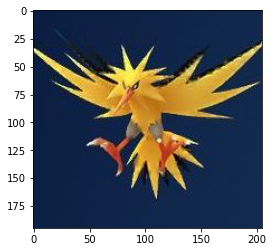

In [9]:
plt.imshow(imread(img_path))

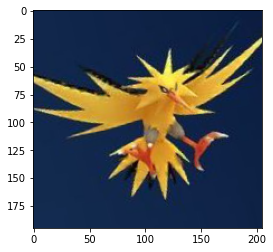

In [10]:
plt.imshow(image_gen.random_transform(imread(img_path)))

In [11]:
image_gen.flow_from_directory(train_path)

Found 6820 images belonging to 150 classes.


In [12]:
image_gen.flow_from_directory(test_path)

Found 2246 images belonging to 150 classes.


<h2> Creating and training model </h2>

In [13]:
# Importing standard libraries for creating and training model

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Setting the inupt image size
image_shape = (256,256,3)

In [15]:
# Creating a CNN model with 5 layers 64,128,128,128 and 256 filters each with 3x3 kernel size and pooling layers with size 2
# Adding 3 dense layers with 1024,512 neurons with final layer with 150 outputs.
# Batch Normalization and Dropout layers

model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(BatchNormalization())
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(512,activation='relu'))

model.add(Dense(150,activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       1

In [17]:
batch_size = 16

In [18]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 6820 images belonging to 150 classes.


In [19]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 2246 images belonging to 150 classes.


In [20]:
# Defining a callback for early stopping to utilize computing resources effeciently
early_stopping = EarlyStopping(monitor='val_loss',patience=3)

In [21]:
# Training the model
results = model.fit(train_image_gen,epochs=80,validation_data=test_image_gen,callbacks=[early_stopping])

Epoch 1/80
427/427 [==============================] - 168s 393ms/step - loss: 5.1391 - accuracy: 0.0160 - val_loss: 4.5870 - val_accuracy: 0.0183
Epoch 2/80
427/427 [==============================] - 166s 388ms/step - loss: 4.3431 - accuracy: 0.0465 - val_loss: 4.0997 - val_accuracy: 0.0663
Epoch 3/80
427/427 [==============================] - 166s 389ms/step - loss: 3.8585 - accuracy: 0.0894 - val_loss: 3.3251 - val_accuracy: 0.1527
Epoch 4/80
427/427 [==============================] - 166s 388ms/step - loss: 3.4536 - accuracy: 0.1419 - val_loss: 3.2210 - val_accuracy: 0.1821
Epoch 5/80
427/427 [==============================] - 167s 391ms/step - loss: 3.1786 - accuracy: 0.1968 - val_loss: 2.7853 - val_accuracy: 0.2725
Epoch 6/80
427/427 [==============================] - 166s 388ms/step - loss: 2.9393 - accuracy: 0.2477 - val_loss: 2.5500 - val_accuracy: 0.3317
Epoch 7/80
427/427 [==============================] - 167s 390ms/step - loss: 2.7274 - accuracy: 0.2796 - val_loss: 2.4283 -

In [22]:
#loss_history = pd.read_csv("loss_history.csv")

In [23]:
#model = load_model("my_cnn_model.h5")

In [24]:
#Recording the loss history
loss_history = pd.DataFrame(model.history.history)

In [25]:
loss_history.to_csv('loss_history.csv')

In [26]:
# Saving the trained model
model.save('my_cnn_model.h5')

<h2> Evaluating the model </h2>

In [27]:
model.evaluate(test_image_gen)

141/141 [==============================] - 42s 298ms/step - loss: 1.2108 - accuracy: 0.6594


[1.2107975482940674, 0.6593945026397705]

In [28]:
loss_history.head()

,loss,accuracy,val_loss,val_accuracy
0,5.139116,0.015982,4.586981,0.018255
1,4.343059,0.046481,4.099666,0.066340
2,3.858486,0.089443,3.325058,0.152716
3,3.453553,0.141935,3.221005,0.182102
4,3.178632,0.196774,2.785251,0.272484


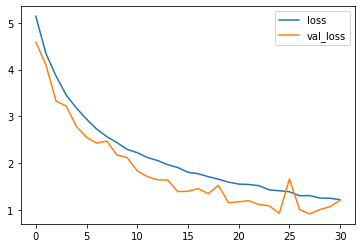

In [29]:
# plotting the loss
loss_history[['loss','val_loss']].plot()

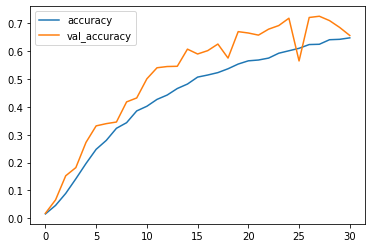

In [30]:
# plotting the accuracy
loss_history[['accuracy','val_accuracy']].plot()

<h2> Testing the model on new image </h2>

In [31]:
# Importing standard libraries for image and web url
from tensorflow.keras.preprocessing import image
from PIL import Image
import urllib.request

In [32]:
def predict_pokemon(img_url):

  # Fetching Image URL 
  url = img_url
  test_image_path = urllib.request.urlopen(url)
  
  # Using Image lib to resize image
  img = Image.open(test_image_path)
  img = img.resize((256,256))
  
  plt.imshow(img)
  plt.show()
  
  # Dropping the transperency channel if it exists
  
  img = np.array(img)
  if img.shape[2] != 3:
      img = img[:,:,:3]
  
  # Converting to array, normalizing and expanding the dims
  
  img = img/255
  my_img_array = np.expand_dims(img,axis=0)

  # Fething the prediction
  pred_class = np.argmax(model.predict(my_img_array),axis=-1)
  poke_class = {value:key for key,value in train_image_gen.class_indices.items()}
  print(poke_class[pred_class[0]])

In [33]:
img = 'http://www.pngmart.com/files/12/Pokemon-Charizard-PNG-Image.png'
img2 = 'https://www.pngkey.com/png/full/149-1492440_pokemon-jigglypuff-png-jigglypuff-pokemon.png'
img3 = 'https://smallimg.pngkey.com/png/small/62-623293_pokemon-conquest-pokemon-art.png'
img4 = 'https://smallimg.pngkey.com/png/small/1-16272_pokemon-logo-png-transparent-pokemon-vector.png'
img5 = 'https://www.pngkey.com/png/full/62-622689_fire-pokemon-png-moltres-pokemon.png'
img6 = 'https://www.pngkey.com/png/full/66-668441_jpg-library-library-redo-ultimate-mewtwo-by-pokemon.png'

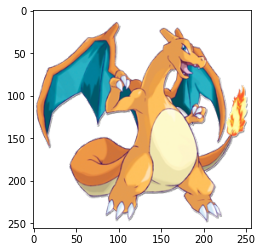

Charizard


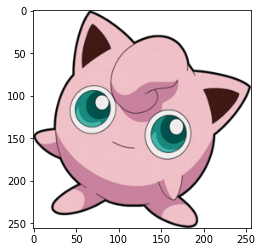

Jigglypuff


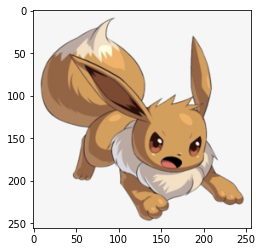

Eevee


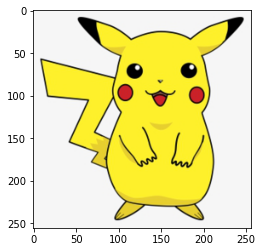

Pikachu


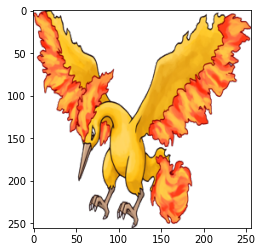

Moltres


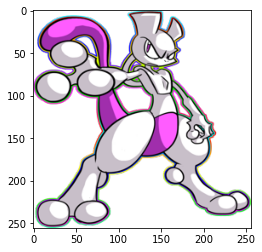

Mewtwo


In [34]:
pokemon = [img,img2,img3,img4,img5,img6]

for i in pokemon:
  predict_pokemon(i)